In [21]:

from dotenv import load_dotenv
load_dotenv()

True

In [32]:
import os
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGSMITH,_API_KEY']=os.getenv('LANGCHAIN_API_KEY')

llm = ChatGroq(model="qwen/qwen3-32b")
response=llm.invoke("Hello")
response.content

'<think>\nOkay, the user said "Hello". That\'s a greeting. I should respond in a friendly and welcoming way. Maybe ask how I can assist them today. Keep it open-ended so they can specify what they need help with. Use an emoji to keep the tone positive. Let me make sure the response is concise but not too short.\n</think>\n\nHi there! 😊 How can I assist you today?'

In [34]:

llm_open_ai = ChatOpenAI(model="gpt-4o")
response_open_ai=llm_open_ai.invoke("Hello")
response_open_ai.content

'Hello! How can I assist you today?'

In [35]:
from typing import Annotated,List
from typing_extensions import Literal
import operator
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

#Graph State

class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str
    

In [36]:
### Custom tools

def add(a:int,b:int) -> int :
    """Adds a and b
    Args:
        a: first int
        b: second int
    Returns
        int    
    """
    return a+b

def div(a:int,b:int) -> int :
    """Divide a and b
    Args:
        a: first int
        b: second int
    Returns
        int    
    """
    return a/b

def mul(a:int,b:int) -> int :
    """Multiply a and b
    Args:
        a: first int
        b: second int
    Returns
        int    
    """
    return a*b

def sub(a:int,b:int) -> int :
    """ASubstractiondds a and b
    Args:
        a: first int
        b: second int
    Returns
        int    
    """
    return a-b

tools=[add,mul,sub,div]

In [37]:
### INtegrate custom tools with llm

llm_with_tools=llm.bind_tools(tools)
llm_with_tools_open_ai=llm_open_ai.bind_tools(tools)
# llm_with_tools
llm_with_tools_open_ai

RunnableBinding(bound=ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7f86b90ff5c0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f86b8940860>, root_client=<openai.OpenAI object at 0x7f86b9042b70>, root_async_client=<openai.AsyncOpenAI object at 0x7f86b90fc8f0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b\nArgs:\n    a: first int\n    b: second int\nReturns\n

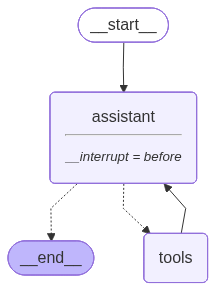

In [48]:
## Workflow with langgraph
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

sys_msg=SystemMessage(content="You are a helpful assistant tasked ith performing arithmetic on a series of input ")

# def assistant(state:MessagesState):
#     return {"messags":[llm_with_tools.invoke([sys_msg]+state["messages"])]}


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools_open_ai.invoke([sys_msg]+state["messages"])]}


# buil a graph
builder=StateGraph(State)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START,"assistant")

builder.add_conditional_edges(
    "assistant",
    tools_condition
    ) 
builder.add_edge("tools","assistant")
memory = MemorySaver()


# compile the graph
#human in the loop
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

#Visualize thegraph 
graph_image=graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [49]:
#run the graph
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    # print(event)
    event['messages'][-1].pretty_print()



In [50]:
state=graph.get_state(thread)
state.next

('assistant',)